# 2024-1 DSL 정규세션 과제

## CNN Assignment

- 작성자 : 윤형진
- 참고자료 : PyTorch Document
- 과제 제출 기한 : 02.18

---
- 이름 : 김민석
- 기수 : 11기    



## 해당 과제에는 6개의 섹션과 7개의 문제가 있습니다! 누락없이 제출 부탁드립니다 :)

In [1]:
#pip install wandb

In [2]:
'''
# colab 환경에서 학습을 진행하실 분들은 구글드라이브를 연동해주세요
from google.colab import drive
drive.mount('/content/drive')
'''

"\n# colab 환경에서 학습을 진행하실 분들은 구글드라이브를 연동해주세요\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [3]:
# 이번 과제의 일부였던 CustomDataset.py, Model.py를 로드해주세요
from CustomDataset import CustomImageDataset
from Model import ResNet50

import pandas as pd
import numpy as np

import yaml
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [4]:
# config.yaml의 위치를 지정해주세요
config_path = "/Users/minseok/Downloads/[240206]_CNN_YOURNAME/scripts/config.yaml"

# 1. 하이퍼파라미터 및 기타 주요 변수 설정

config.yaml에 지정해줬던 디렉토리, 모델 하이퍼파라미터들을 가져옵시다

In [5]:
# config.yaml에서 디렉토리, 모델 하이퍼파라미터를 각각 받아옵니다
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

dataset_direc, meta_direc, weight_direc \
    = config["Direc"]["DatasetDirec"], \
      config["Direc"]["MetaDataDirec"], \
      config["Direc"]["WeightDirec"]

epoch, batch_size, lr \
    = config["HyperParameters"]["Epoch"], \
      config["HyperParameters"]["BatchSize"], \
      float(config["HyperParameters"]["LearningRate"]) # config.yaml에서 이미 float 자료형으로 학습률을 정의하신 분은 float()으로 자료형 변환을 하지 않으셔도 됩니다.



In [6]:
import wandb # wandb.ai으로의 실시간 연동을 위한 라이브러리 임포트
from signal import signal, SIGPIPE, SIG_DFL
#Ignore SIG_PIPE and don't throw exceptions on it... (http://docs.python.org/library/signal.html)
signal(SIGPIPE,SIG_DFL)

# wandb login
'''
wandb.init(
    project="DSL_ResNet", entity=<여러분의 wandb.ai 아이디>,
    name=<project 안에 저장될 개별 Run의 이름>,
    config={
        "model_name": <project 안에 저장될 개별 Run의 이름>,
        "epochs": <config.yaml에서 가져온 에포크>,
        "batch_size": <config.yaml에서 가져온 batch size>,
        "lr": <config.yaml에서 가져온 학습률>
    })

config = wandb.config
'''

wandb.init(
    project="DSL_ResNet", entity='minseok329',
    name="run_augmentation",
    config={
        "model_name": f"augmentation_model_lr({lr})",
        "epochs": epoch,
        "batch_size": batch_size,
        "lr": lr
    })

config = wandb.config


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: minseok329. Use `wandb login --relogin` to force relogin


In [7]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps:0


In [8]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
#!python -c 'import platform;print(platform.platform())'

PyTorch version:2.2.0
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True


# 2. train, val, test DataLoader 초기화

### 문제 1. 

모델의 학습을 train, validation, test로 나눠서 진행하는 이유는 무엇인가요? 
- (힌트 : 굳이 validation을 끼워넣는 이유는 무엇인가요?)

오버피팅을 방지하기 위해

### 문제 2. 

모델의 generalization을 높여주기 위해 Augmentation을 사용할 수 있다고 했습니다. 

PyTorch 구현상으로는 train, validation, test 모든 단계에 Augmention를 구현할 수 있습니다만, 실제로는 특정 단계에서만 Augmention를 수행하게 됩니다. 어느 단계에서 RandAugment가 적용되어야하는지와, 그 이유에 대해서 설명해주세요.

train 단계 논리적으로도 , 코드 구현상으로도 train에서만 진행

### 문제 3. 
CustomImageDataset과 DataLoader 클래스의 차이점에 대해서 설명해주세요.
- 
모든 데이터셋을 불러들이고 사용하는것이 아니라 한번에 하나씩 불러서 사용

In [9]:
# MetaData.csv를 로드해주고, train, val, test로 나눠줍니다
meta_data = pd.read_csv('/Users/minseok/Downloads/[240206]_CNN_YOURNAME/scripts/MetaData.csv')

# train : val : test = 6 : 2 : 2
train, val_test = train_test_split(meta_data, train_size=0.6, random_state=777)
val, test = train_test_split(val_test, train_size=0.5, random_state=777)

# Model generalization을 위해 RandomAugmentation에 어떤 변형을 가할 지 transforms.Compose([])로 묶어놓읍시다
train_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ColorJitter(brightness=[0.5, 1.5]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

])

# CustomDataset.py에서 가져온 CustomImageDataset 클래스에 train, val, test 데이터프레임을 패스하여 데이터셋을 만들어주세요
train_dataset = CustomImageDataset(dataset_direc=dataset_direc, df= train, transform = train_transforms)
val_dataset   = CustomImageDataset(dataset_direc=dataset_direc, df= val, transform = None)
test_dataset  = CustomImageDataset(dataset_direc=dataset_direc, df= test, transform = None)


train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [10]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 1)

# 3. 모델 초기화, 손실함수 및 optimizer 지정

### 문제 4. 

주어진 과제는 Binary Classification 태스크입니다. 

이중 분류를 위해서는 손실함수로 Binary Cross Entropy를 사용한다고 세션에서 배웠습니다.

PyTorch에는 Binary Cross Entropy를 학습에 사용할 수 있는 2가지 방법이 있는데요, 'nn.BCELoss'와 'nn.BCEWithLogitsLoss'입니다. 

이 둘은 같아 보이지만 구현상에서 명백한 차이점이 있습니다.

이 둘의 차이점에 대해서 서술해주세요.

'nn.BCELoss'와 'nn.BCEWithLogitsLoss'는 둘 다 이진 분류 작업에서 사용할 수 있는 손실 함수입니다. 그러나 두 가지의 중요한 차이점이 있습니다.

입력 형식:
nn.BCELoss: 이 함수는 로짓(logit) 값이 아닌 확률 값을 입력으로 받습니다. 즉, 이 함수에는 확률 값이 입력되어야 합니다. 이러한 경우에는 확률 값을 계산하기 위해 sigmoid 함수를 적용해야 합니다.
nn.BCEWithLogitsLoss: 이 함수는 로짓 값 자체를 입력으로 받습니다. 즉, sigmoid 함수를 적용하기 전의 로짓 값을 입력으로 받습니다. 이 함수는 내부적으로 sigmoid 함수를 포함하고 있으므로 sigmoid 함수를 따로 적용할 필요가 없습니다.
수치적 안정성(numerical stability):
nn.BCEWithLogitsLoss는 수치적 안정성(numerical stability)을 높일 수 있습니다. 로짓 값이 큰 경우에는 sigmoid 함수의 출력이 1에 가까워질 수 있고, 작은 경우에는 0에 가까워질 수 있습니다. 이러한 경우에는 시그모이드 함수의 출력이 0 또는 1에 근접하여 손실 함수 값이 발산할 수 있습니다. 따라서 로짓 값을 직접 입력으로 받는 nn.BCEWithLogitsLoss를 사용하면 이러한 문제를 방지할 수 있습니다.
따라서, 일반적으로는 nn.BCEWithLogitsLoss를 사용하는 것이 더 편리하고 안정적입니다. 이 함수는 시그모이드 함수를 따로 적용할 필요 없이 로짓 값을 바로 입력으로 사용할 수 있으며, 수치적 안정성 측면에서도 더 안정적입니다.

In [11]:
# model을 선언하고 GPU에 올려줍니다
model = ResNet50()
model.to(device)

ResNet50(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_1): BasicBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (donwsample): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (conv2_2): BasicBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bi

In [12]:
# 손실함수를 정의해주세요 
criterion = nn.BCEWithLogitsLoss()
# optimizer를 정의해주세요 
optimizer = optim.Adam(model.parameters(), lr= lr)

# 4. Training 시작

학습을 위한 모든 준비가 끝났습니다! ㄱㅂㅈㄱ

### 문제 5. 
학습이 끝난 이후 val_loss, train_loss 변화 추이 그래프와 val_acc, train_acc 변화 추이 그래프를 첨부해주세요.
(wandb 대시보드에서 캡쳐하셔도 됩니다)

In [13]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 1)

In [14]:
weight_direc

'/Users/minseok/Downloads/[240206]_CNN_YOURNAME/BestModel'

In [15]:
lr

0.01

In [16]:
# Best Validation Loss를 양의 무한대로 초기화
best_loss = float("inf")


# Training, Validation 시작

import tqdm
for curr_epoch in tqdm.tqdm(range(epoch+1)): # iterate over all EPOCHS
  train_loss = 0
  correct_train = 0

  for img, label in (train_loader): # iterate over all BATCHES
                     
    # GPU에 올라가는 건 모델 뿐 아니라 데이터도 같이 올라가야합니다!
    img, label = img.to(device), label.to(device)

    # Forward Propagation
    pred = model(img)

    # 손실함수 계산
    loss = criterion(pred, label.float()) # 구현상의 차이로 label 텐서에 조작을 가해 모양을 맞춰줘야하는 경우가 생길 수 있습니다 ( 힌트 : tensor.view() )

    # 누적된 기울기 초기화 및 역전파
    optimizer.zero_grad()
    loss.backward()

    # 파라미터 업데이트
    optimizer.step()

    # 해당 Batch에서의 loss를 train_loss 변수에 누적
    train_loss += loss.item()

    # Accuracy 계산
    pred_class = (torch.sigmoid(pred) > 0.5).float()
    correct_train += (pred_class == label).float().sum()

  # 모든 Batch를 순회한 이후 최종적인 train_loss, train_acc를 계산해줍니다
  train_loss = train_loss/len(train_loader)
  train_acc = correct_train /len(train_loader)

  # Validation 시작
  model.eval()  

  with torch.no_grad():  # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않습니다
    val_loss = 0
    correct_val = 0

    for img, label in (val_loader): # iterate over all BATCHES
                       
      ##################################
      # forward propagation, loss 구현  #
      ##################################
                       
      val_loss += loss.item()

      # 모든 Batch를 순회한 이후 최종적인 val_loss, val_acc를 계산해줍니다
      img, label = img.to(device), label.to(device)
      pred = model(img)
      pred_class = (torch.sigmoid(pred) > 0.5).float()
      correct_val += (pred_class == label).float().sum()

    val_loss /= len(val_loader)
    val_acc = correct_val / len(val_loader)

  # wandb.ai에 보낼 log 데이터를 작성해줍니다.
  metrics = {
    "epoch": epoch,
    "train_loss": train_loss,
    "val_loss" : val_loss,
    "train_acc": train_acc.item(),
    "val_acc" : val_acc.item(),
    "learning_rate": lr
    }

  # 아래 코드를 통해 실시간으로 학습현황을 확인할 수 있도록 log 데이터를 전송해줍니다
  wandb.log(metrics)

  # 모델을 다시 학습모드로 설정합니다
  model.train()

  # 가장 작은 validation loss를 가졌을 때의 모델 파라미터를 저장해줍니다.
  if val_loss < best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(), os.path.join(weight_direc, "best_model(aug).pt")) # .pt 확장자로 저장해주도록합니다

wandb.finish()

100%|██████████| 41/41 [35:24<00:00, 51.81s/it]


![스크린샷 2024-02-18 오후 5.27.20.png](<attachment:스크린샷 2024-02-18 오후 5.27.20.png>)

# 5. Test

학습이 모두 끝났다면, 가장 낮은 validation loss를 기록한 모델의 파라미터를 불러오도록합시다.

이후에는 confusion matrix, accuracy 등을 측정하여 모델이 얼마나 잘 학습되었는지 평가하도록 하겠습니다.

### 문제6. 

accuracy 95% 이상이 되도록 학습률 등을 조절해주세요.
- 못했습니다 ㅜㅜ

In [17]:
trained_model = ResNet50() # 우선 ResNet50 모델 하나를 초기화 해줍니다
trained_model.load_state_dict(torch.load(os.path.join(weight_direc, "best_model(aug).pt"))) # 아까 저장해둔 weight를 로드해줍니다
trained_model.eval() # 모델을 evaluation 모드로 설정합니다
trained_model.to(device) 

ResNet50(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_1): BasicBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (donwsample): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (conv2_2): BasicBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bi

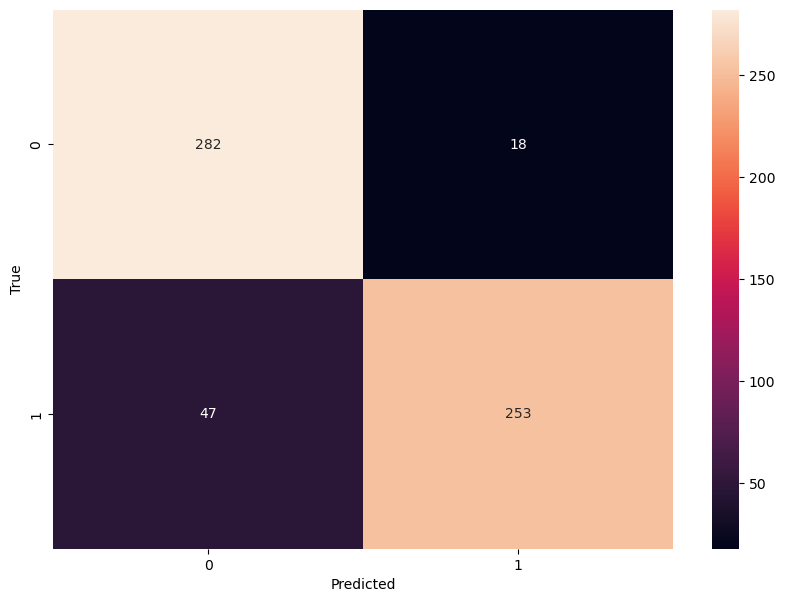

Accuracy: 89.17%


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

all_labels = []
all_predictions = []

for image, label in (test_loader):
  image, label = image.to(device), label.to(device)

  with torch.no_grad(): # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않습니다
    pred = model(image) # 순전파

    probabilities = torch.sigmoid(pred) # 시그모이드 함수를 이용해 확률을 계산합니다
    predicted = (probabilities > 0.5).float()  # 확률을 label로 바꿔줍니다

    all_labels.extend(label.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

# Confusion matrix를 그려줍니다
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy도 출력해봅시다
accuracy = accuracy_score(all_labels, all_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# 6. Augmentation vs No Augmentation 

### 문제 7. 

전달받으신 파일들 중, Run_NoAugment.ipynb라는 파일이 있을 겁니다.

지금 보고 계신 노트북과 똑같이 학습을 시키시되, 이번에는 학습 시 data augmentation을 적용시키지 않고 진행하십시오.

이후 augmentation을 적용시키지 않은 모델의 train loss와 val loss의 차트를 아래에 붙여놓으시고, 

augmentation을 적용한 모델의 학습 양상과 어떤 점이 다른 지와 그 이유도 함께 설명해주세요.

![스크린샷 2024-02-18 오후 6.43.17.png](<attachment:스크린샷 2024-02-18 오후 6.43.17.png>)
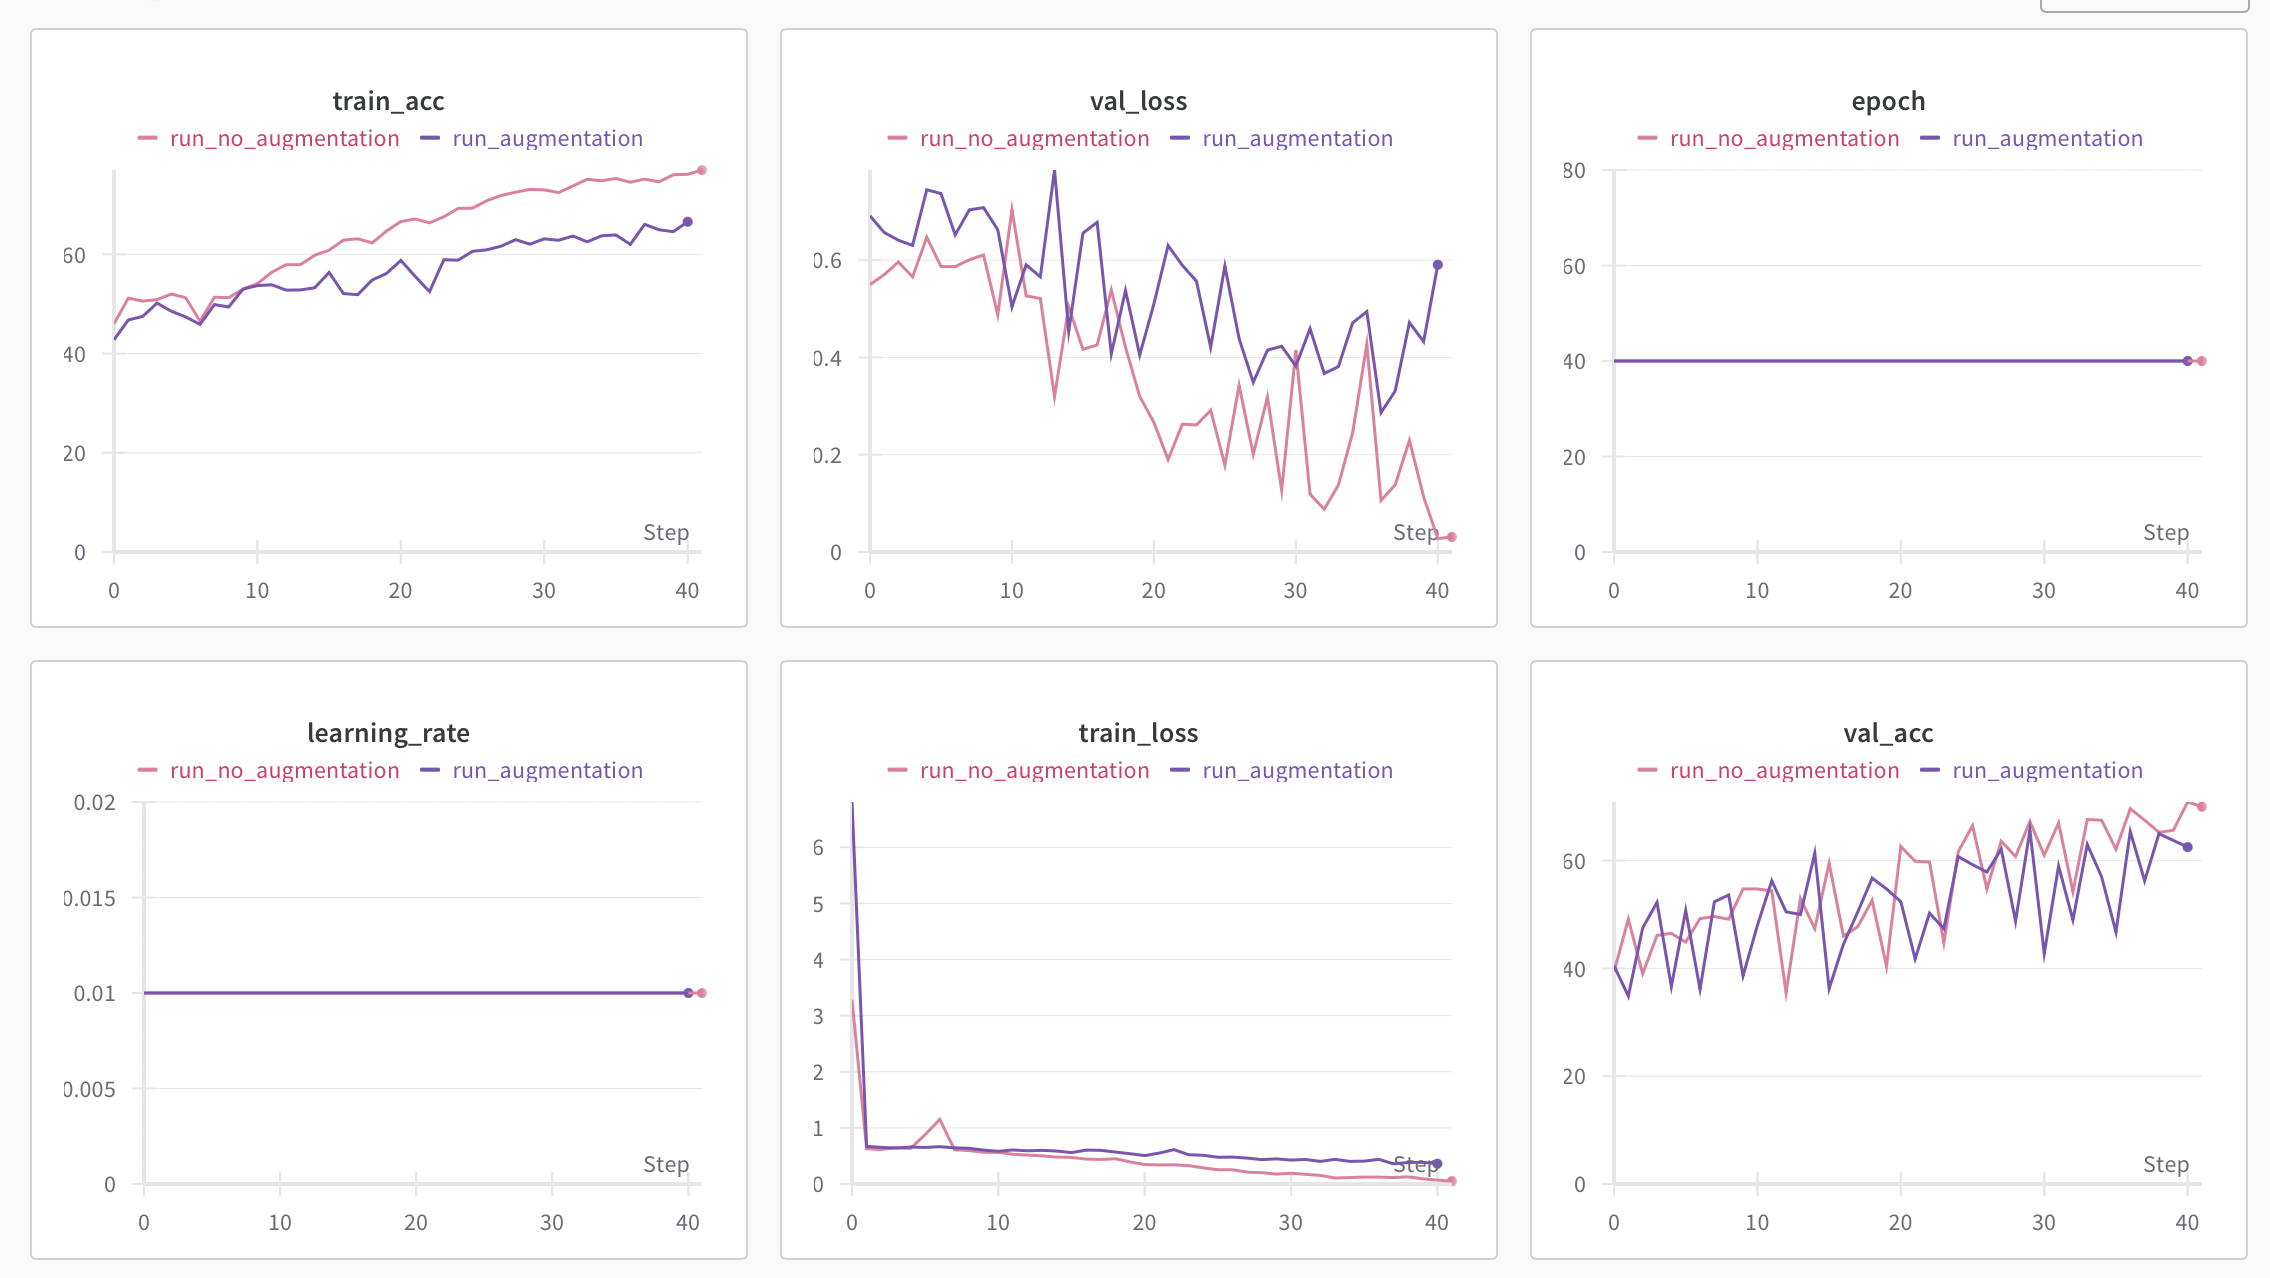

, 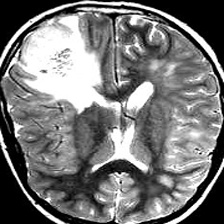

Augmentation을 적용시키지 않은 모델이 더 높은 정확도를 나타내었다. 위 두가지 이미지는 no class 와 yes class 의 이미지인데 해당 도메인에 대한 배경지식이 없어서 정확하지 않을 수 있지만. 이미지에 대한 과도한 변형으로 오히려 모델 성능을 저하시켰을 수 있다